# Imports and constants

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from classifiers.utils.feature_extractors import ColorHistogramTransformer, HuMomentsTransformer, HaralickFeaturesTransformer

from classifiers.utils.load_balanced_data import load_balanced_data_pipeline

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

# Load and preprocess data

In [5]:
metadata_path = "HAM10000_metadata.csv"
image_dir = "HAM10000_images_part_1"

augmented_images, augmented_labels = load_balanced_data_pipeline(metadata_path, image_dir)

Loading balanced data...
Metadata loaded.
Generating image ID list...
Image ID list generated.
Loading images for augmentation...
Augmenting images...
Images augmented.
Data loading complete.


# Train/test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Feature extraction and SVM pipeline

In [13]:
feature_union = FeatureUnion([
    ("color_histogram", ColorHistogramTransformer()),
    ("hu_moments", HuMomentsTransformer()),
    ("haralick_features", HaralickFeaturesTransformer())
])

scaler = StandardScaler()

svc_pipeline = Pipeline([
    ("features", feature_union),
    ("scaler", scaler),
    ("svc", SVC(probability=True))
])

param_grid = {
    "svc__C": [100],
    "svc__gamma": [0.01],
}

grid_search = GridSearchCV(svc_pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train_1d)

# Predict the labels for the test using SVM model
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


# Classification report

In [14]:
# Evaluate the SVM classifier
print("SVM Classification Report:")
print(classification_report(y_test_1d, y_pred))
print("Accuracy:", accuracy_score(y_test_1d, y_pred))
print("Best parameters:", grid_search.best_params_)

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        32
           1       0.68      0.53      0.59        40
           2       0.67      0.80      0.73        35
           3       0.75      0.64      0.69        42
           4       0.52      0.77      0.62        43
           5       0.88      0.69      0.77        42
           6       1.00      0.74      0.85        46

    accuracy                           0.70       280
   macro avg       0.73      0.70      0.70       280
weighted avg       0.74      0.70      0.71       280

Accuracy: 0.7
Best parameters: {'svc__C': 100, 'svc__gamma': 0.01}


In [ ]:
# Confusion matrix

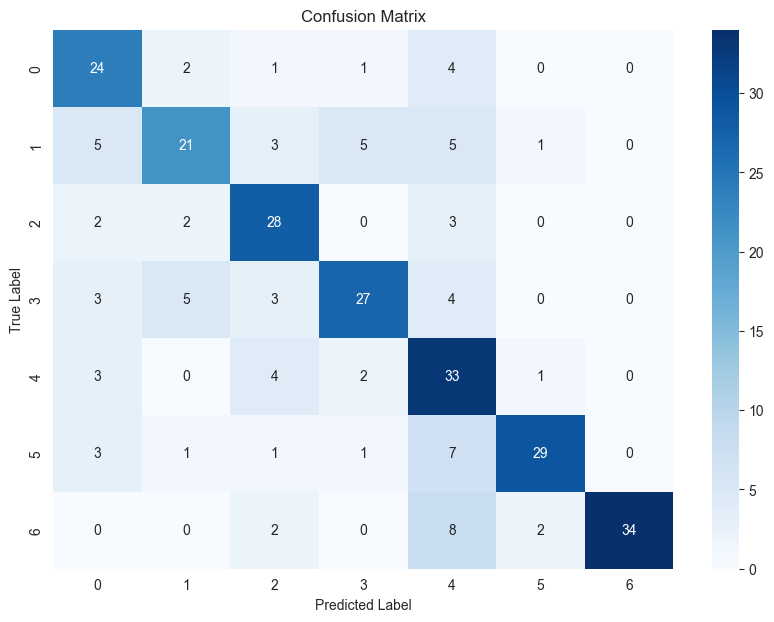

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_1d, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_1d), yticklabels=np.unique(y_test_1d))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC

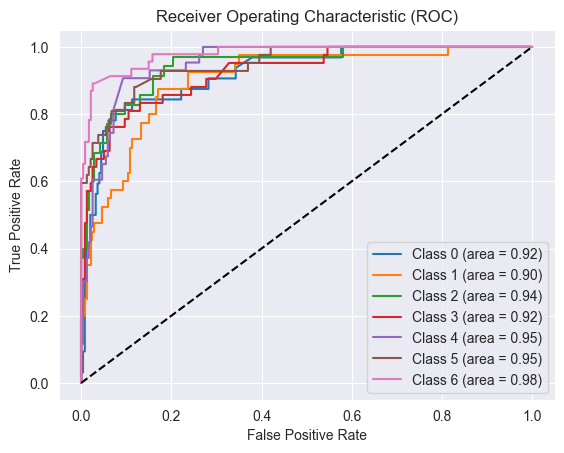

In [16]:
y_score = grid_search.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_train.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_score[:, i])
    
# Plot the ROC curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve

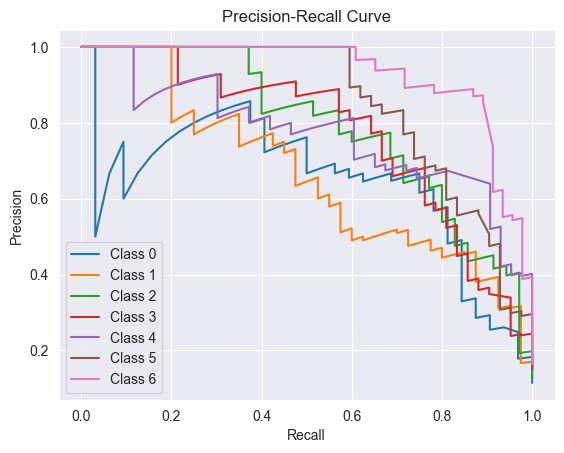

In [17]:
# Compute precision-recall curve for each class
precision = {}
recall = {}
for i in range(y_train.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Save the model

In [18]:
import joblib

joblib_file = "svm.pkl"
joblib.dump(grid_search.best_estimator_, joblib_file)

['svm.pkl']